In [52]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.model_selection import train_test_split
import random
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, PReLU, Bidirectional
from tensorflow.keras.models import Model, Sequential
import os
import sys
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import json

### Cargar datos limpios

In [54]:
sep = os.path.sep
dir_actual = os.path.abspath('')
PATH = sep.join(dir_actual.split(sep)[:-1])
DIR_DATA = PATH + '{0}data{0}'.format(os.sep)
sys.path.append(PATH) if PATH not in list(sys.path) else None
DIR_DATA

'c:\\Users\\USER\\Documents\\Maestria\\CAOBA\\data\\'

In [55]:
data = 'C:/Users/USER/Documents/Maestria/CAOBA/Laura/data/data_clean.csv'
data = pd.read_csv(data)

# Renombrar columna
data.rename(columns={'Error Flag': 'Error_Flag'}, inplace=True)

# Extraer los arrays de numpy
texto = np.array(data['Text'])
labels = np.array(data['Error_Flag'])

In [56]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(texto, labels, test_size= 0.2, random_state= 42)

In [57]:
train_sentences.shape, val_sentences.shape, train_labels.shape, val_labels.shape

((1751,), (438,), (1751,), (438,))

In [58]:
max_vocab_len = 20000

text_vector = TextVectorization(max_tokens = max_vocab_len, 
                                standardize = "lower_and_strip_punctuation",
                                split = 'whitespace',
                                ngrams = 3,
                                output_mode = 'int',
                                output_sequence_length = 124,
                                pad_to_max_tokens = True,
                                vocabulary = None)

In [59]:
text_vector.adapt(train_sentences)

In [60]:
random_sentence = random.choice(train_sentences)
print(f"Original: \n {random_sentence}  \n \n Vector: \n {text_vector([random_sentence])}")

Original: 
 a 22-year-old woman comes to the physician for the evaluation of irregular menstrual bleeding. menses have occurred at 45- to 90-day intervals since menarche at the age of 15 years. her last menstrual period was 5 weeks ago. the patient reports that she was too embarrassed to discuss this issue with anyone until now. over the past two years, she was unable to become pregnant despite having unprotected sexual intercourse with her husband on a regular basis. there is no personal or family history of serious illness. she is 170 cm (5 ft 7 in) tall and weighs 85 kg (187 lb); bmi is 29.4 kg/m2. her vital signs are within normal limits. examination shows oily skin and severe facial acne. there is abnormal pigmented hair on the upper lip and around both nipples. the patient wishes to have children. in addition to recommending lifestyle modifications, clomiphene therapy was recommended.  
 
 Vector: 
 [[    5  1813    66    49     7     2    32    13     2   369     6  1046
    755

In [61]:
print(f" 5 most common words : {text_vector.get_vocabulary()[:5]} \n \n 5 least common words : {text_vector.get_vocabulary()[-5:]}")

 5 most common words : ['', '[UNK]', 'the', 'is', 'and'] 
 
 5 least common words : ['cannot recall any', 'cannot be scraped', 'cancer a', 'can t', 'came back']


In [62]:
embedding = layers.Embedding(input_dim = max_vocab_len, output_dim = 16, embeddings_initializer= 'uniform', input_length = 124)

In [63]:
print(f"original: \n {random_sentence} \n\n Embedded : \n{embedding(text_vector([random_sentence]))}")

original: 
 a 22-year-old woman comes to the physician for the evaluation of irregular menstrual bleeding. menses have occurred at 45- to 90-day intervals since menarche at the age of 15 years. her last menstrual period was 5 weeks ago. the patient reports that she was too embarrassed to discuss this issue with anyone until now. over the past two years, she was unable to become pregnant despite having unprotected sexual intercourse with her husband on a regular basis. there is no personal or family history of serious illness. she is 170 cm (5 ft 7 in) tall and weighs 85 kg (187 lb); bmi is 29.4 kg/m2. her vital signs are within normal limits. examination shows oily skin and severe facial acne. there is abnormal pigmented hair on the upper lip and around both nipples. the patient wishes to have children. in addition to recommending lifestyle modifications, clomiphene therapy was recommended. 

 Embedded : 
[[[-0.03836261  0.02729437  0.0026627  ... -0.02517726  0.01304357
    0.03351441

## LSTM

In [111]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [112]:
modelo = Sequential([
    text_vector,
    Embedding(input_dim=20000, output_dim=16),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dense(64),  # Elimina el argumento de activación aquí
    PReLU(),    # Añade PReLU como una capa separada
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [113]:
modelo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [114]:
history = modelo.fit(train_sentences, train_labels, epochs=5, validation_data=(val_sentences, val_labels), callbacks=[early_stopping], batch_size=64)

Epoch 1/5
28/28 [==============================] - 12s 231ms/step - loss: 0.6882 - accuracy: 0.5545 - val_loss: 0.6918 - val_accuracy: 0.5365
Epoch 2/5
28/28 [==============================] - 5s 176ms/step - loss: 0.6854 - accuracy: 0.5608 - val_loss: 0.6912 - val_accuracy: 0.5365
Epoch 3/5
28/28 [==============================] - 5s 173ms/step - loss: 0.6871 - accuracy: 0.5642 - val_loss: 0.6949 - val_accuracy: 0.5365
Epoch 4/5
28/28 [==============================] - 5s 178ms/step - loss: 0.6828 - accuracy: 0.5620 - val_loss: 0.7121 - val_accuracy: 0.5365
Epoch 5/5
28/28 [==============================] - 5s 175ms/step - loss: 0.6611 - accuracy: 0.5797 - val_loss: 0.7735 - val_accuracy: 0.3402


In [115]:
train_predictions = modelo.predict(train_sentences)
train_predicted_labels = np.round(train_predictions).astype(int).flatten()

55/55 [==============================] - 4s 53ms/step


In [116]:
val_predictions = modelo.predict(val_sentences)
val_predicted_labels = np.round(val_predictions).astype(int).flatten()

14/14 [==============================] - 1s 45ms/step


In [117]:
# Métricas para el conjunto de entrenamiento
train_accuracy = accuracy_score(train_labels, train_predicted_labels)
train_precision = precision_score(train_labels, train_predicted_labels, average='weighted')
train_recall = recall_score(train_labels, train_predicted_labels, average='weighted')
train_f1 = f1_score(train_labels, train_predicted_labels, average='weighted')

# Métricas para el conjunto de validación/test
val_accuracy = accuracy_score(val_labels, val_predicted_labels)
val_precision = precision_score(val_labels, val_predicted_labels, average='weighted')
val_recall = recall_score(val_labels, val_predicted_labels, average='weighted')
val_f1 = f1_score(val_labels, val_predicted_labels, average='weighted')

# Imprimir las métricas
print("Training Metrics:")
print(f"Accuracy: {train_accuracy}")
print(f"Precision: {train_precision}")
print(f"Recall: {train_recall}")
print(f"F1 Score: {train_f1}")

print("\nValidation/Test Metrics:")
print(f"Accuracy: {val_accuracy}")

Training Metrics:
Accuracy: 0.6881781838949171
Precision: 0.705578065422272
Recall: 0.6881781838949171
F1 Score: 0.6887000448966876

Validation/Test Metrics:
Accuracy: 0.3401826484018265


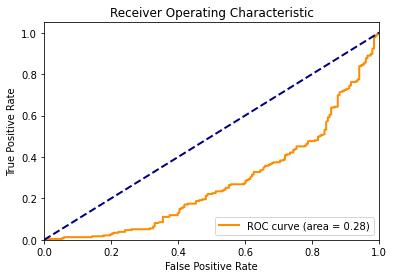

In [118]:
# Calcular las tasas de verdaderos y falsos positivos y el umbral
fpr, tpr, thresholds = roc_curve(val_labels, val_predictions)

# Calcular el área bajo la curva ROC (AUC)
roc_auc = auc(fpr, tpr)

# Generar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

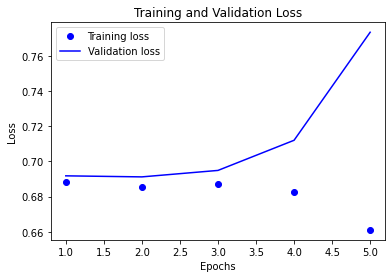

In [119]:
# Extraer la pérdida de entrenamiento y validación de la historia del entrenamiento
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Determinar el número de épocas
epochs = range(1, len(train_loss) + 1)

# Crear el gráfico
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

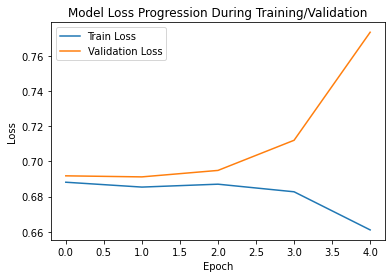

In [120]:
# Graficar la pérdida de entrenamiento y validación
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression During Training/Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [121]:
# Adaptar el vectorizador a tus datos de entrenamiento
text_vector.adapt(train_sentences)

# Obtener el vocabulario del vectorizador
vocab = text_vector.get_vocabulary()

# Guardar el vocabulario en un archivo
vocab_path = 'C:/Users/USER/Documents/Maestria/CAOBA/Laura/data/text_vocab.json'
with open(vocab_path, 'w') as f:
    json.dump(vocab, f)


In [122]:
model_path = 'C:/Users/USER/Documents/Maestria/CAOBA/Laura/data/my_nlp_model_tf'
modelo.save(model_path, save_format='tf')

INFO:tensorflow:Assets written to: C:/Users/USER/Documents/Maestria/CAOBA/Laura/data/my_nlp_model_tf\assets


INFO:tensorflow:Assets written to: C:/Users/USER/Documents/Maestria/CAOBA/Laura/data/my_nlp_model_tf\assets
